# Классификация с помощью kNN. Кластеризация K-means

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

In [2]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

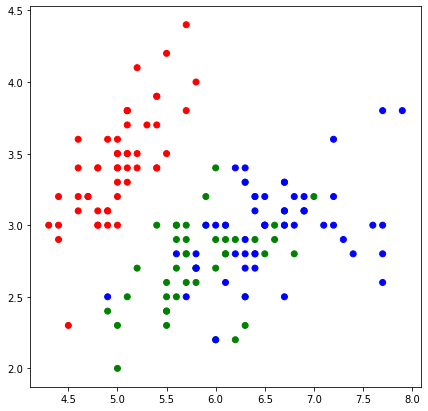

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [5]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [6]:
def knn(x_train, y_train, x_test, k):
    answers = []
    for x in x_test:
        test_distances = []
        for i in range(len(x_train)):
            distance = e_metrics(x, x_train[i])
            test_distances.append((distance, y_train[i]))
        classes = {class_item: 0 for class_item in set(y_train)}
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [8]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
    h = .02
    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [9]:
k = 10
y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.833


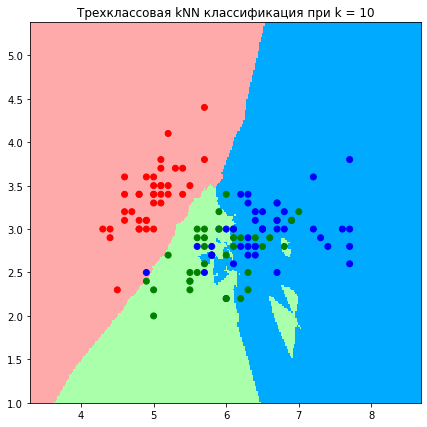

Wall time: 1min 14s


In [10]:
%%time
get_graph(X_train, y_train, k)

In [11]:
from sklearn.datasets import make_blobs
import random
X, y = make_blobs(n_samples=100, random_state=1)

In [12]:
def kmeans(data, k, max_iterations, min_distance):    
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        classes = {i: [] for i in range(k)}
        for x in data:
            distances = [e_metrics(x, centroid) for centroid in centroids]
            classification = distances.index(min(distances))
            classes[classification].append(x)
        old_centroids = centroids.copy()
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
        if optimal:
            break
    return old_centroids, classes

In [13]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(7,7))
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
    plt.show()

In [14]:
max_iterations = 10
min_distance = 1e-4
k = 3

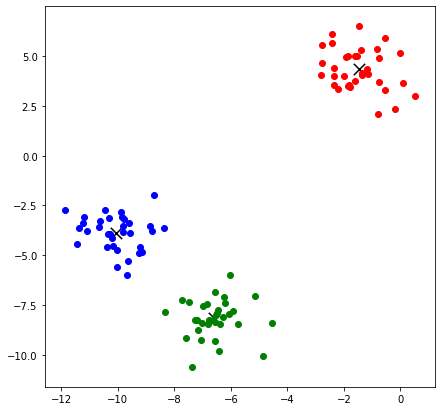

In [15]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)
visualize(centroids, clusters)

## Домашнее задание

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов соседей по любому из показанных на уроке принципов.

In [16]:
# Реализуем функцию расчёта весов по дистанции между объектами

def calc_weight(distance):
    epsilon = 1e-5
    weight = 1 / (distance + epsilon)
    return weight

In [17]:
# Реализуем функцию предсказания значения, с учётом весов
from itertools import combinations

def calc_prediction(weights):
    weighted_sum = 0
    weight_product = 1
    combination_sum = 0

    for value, weight in weights.items():
        weighted_sum += value/weight
        weight_product *= weight
    # список из комбинаций длиной len(weights.values())-1 из weights.values() без повторяющихся элементов.
    for x in list(combinations(weights.values(), len(weights.values())-1)):
        combination_sum += np.prod(x)

    prediction = (weight_product/combination_sum) * weighted_sum

    return prediction

In [18]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
    
        # Сортируем список и среди первых k элементов подсчитаем веса этих элементов, основанные на дистанции до них
        weights = {}
        for d in sorted(test_distances)[:k]:
            weights[d[1]] = calc_weight(d[0])
            
        answers.append(calc_prediction(weights))
        
    return answers

###### Вывод: функция построена

2. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от k (взять от 1 до 10) для выборки данных из данного урока.

In [19]:
# Реализуем функцию вычисления среднего квадратичного внутриклассового расстояния
def calc_inner_distance(centroids, clusters):
    distances = np.zeros(len(centroids))
    result = 0

    for i, centroid in enumerate(centroids):
        for x in clusters[i]:
            distances[i] += e_metrics(x, centroid)**2
        result += distances[i] / len(clusters[i])
    return result

In [20]:
# Построим несколько моделей с разным количество кластеров
clusters_count_list = list(range(1,11))
cls = [kmeans(X, k, max_iterations, min_distance) for k in clusters_count_list]
inner_distances = [calc_inner_distance(centroids, clusters) for centroids, clusters in cls]

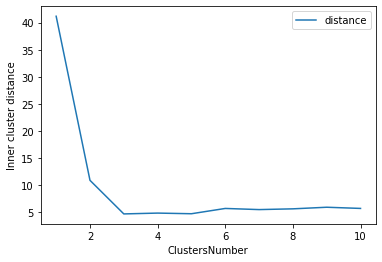

In [21]:
# Построим на графике зависимость среднеквадратичного внутрикластерного рассотояния от количества кластеров
plt.xlabel('ClustersNumber')
plt.ylabel('Inner cluster distance')
plt.plot(clusters_count_list, inner_distances, label='distance')
plt.legend(loc='upper right')
plt.show()

##### Вывод: 1) функция написана и график построен; 2) на данном дата-сете с алгоритмом KNN оптимальным является количество кластеров равным 3.